In [11]:
import pyspark

In [12]:
myConf=pyspark.SparkConf()
spark=pyspark.sql.SparkSession.builder.master("local").appName("myApp").config(conf=myConf).getOrCreate()

In [13]:
file_name="http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

In [14]:
import pandas as pd

column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
abalone = pd.read_csv(file_name, names=column_names)

In [15]:
abalone.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [16]:
abalone["age"] = 1.5 * abalone["rings"]

In [17]:
abalone.sample(n=5)

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,age
1454,I,0.470,0.355,0.120,0.3685,0.1260,0.0835,0.1365,6,9.0
3761,M,0.530,0.420,0.135,0.6750,0.2940,0.1560,0.1825,10,15.0
1134,F,0.570,0.445,0.145,0.8775,0.4120,0.2170,0.2200,8,12.0
43,I,0.205,0.150,0.055,0.0420,0.0255,0.0150,0.0120,5,7.5
2084,F,0.690,0.540,0.195,1.2525,0.7300,0.3975,0.4620,12,18.0


In [18]:
abalone['Male'] = (abalone['sex']=='M').astype(int)
abalone['Female'] = (abalone['sex']=='F').astype(int)
abalone['Infant'] = (abalone['sex']=='I').astype(int)

In [19]:
abalone.sample(n=5)

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,age,Male,Female,Infant
2669,M,0.590,0.470,0.150,0.861,0.4130,0.1640,0.2490,8,12.0,1,0,0
2875,I,0.435,0.335,0.095,0.298,0.1090,0.0580,0.1150,7,10.5,0,0,1
71,F,0.400,0.320,0.110,0.353,0.1405,0.0985,0.1000,8,12.0,0,1,0
3291,M,0.530,0.405,0.130,0.738,0.2845,0.1700,0.1930,9,13.5,1,0,0
2851,F,0.635,0.510,0.185,1.286,0.5260,0.2950,0.4105,12,18.0,0,1,0


In [37]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[("sex", OneHotEncoder(handle_unknown='ignore'), [0])],
                       remainder = 'passthrough')
X = ct.fit_transform(abalone)

In [38]:
_abalone = pd.DataFrame(X)

In [39]:
abalaoneDf=spark.createDataFrame(abalone)

In [40]:
abalaoneDf.printSchema()

root
 |-- sex: string (nullable = true)
 |-- length: double (nullable = true)
 |-- diameter: double (nullable = true)
 |-- height: double (nullable = true)
 |-- whole weight: double (nullable = true)
 |-- shucked weight: double (nullable = true)
 |-- viscera weight: double (nullable = true)
 |-- shell weight: double (nullable = true)
 |-- rings: long (nullable = true)
 |-- age: double (nullable = true)
 |-- Male: long (nullable = true)
 |-- Female: long (nullable = true)
 |-- Infant: long (nullable = true)



In [41]:
abalaoneDf.groupBy('sex').agg({"age":"avg"}).show()

+---+------------------+
|sex|          avg(age)|
+---+------------------+
|  F| 16.69395562356542|
|  M| 16.05824607329843|
|  I|11.835692995529062|
+---+------------------+



In [42]:
abalaoneDf.show()

+---+------+--------+------+------------+-------------------+-------------------+------------+-----+----+----+------+------+
|sex|length|diameter|height|whole weight|     shucked weight|     viscera weight|shell weight|rings| age|Male|Female|Infant|
+---+------+--------+------+------------+-------------------+-------------------+------------+-----+----+----+------+------+
|  M| 0.455|   0.365| 0.095|       0.514|             0.2245|0.10099999999999999|        0.15|   15|22.5|   1|     0|     0|
|  M|  0.35|   0.265|  0.09|      0.2255|             0.0995|             0.0485|        0.07|    7|10.5|   1|     0|     0|
|  F|  0.53|    0.42| 0.135|       0.677|             0.2565|             0.1415|        0.21|    9|13.5|   0|     1|     0|
|  M|  0.44|   0.365| 0.125|       0.516|             0.2155|              0.114|       0.155|   10|15.0|   1|     0|     0|
|  I|  0.33|   0.255|  0.08|       0.205|             0.0895|             0.0395|       0.055|    7|10.5|   0|     0|     1|


In [26]:
(trainDf, testDf) = abalaoneDf.randomSplit([0.6, 0.4])

In [43]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="sex", outputCol="sexIndex")
#siModel = stringIndexer.fit(trainDf)
#siDf = siModel.transform(trainDf)

In [44]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="sexIndex", outputCol="sexVec")
#enModel = encoder.fit(trainDf)
#enDf = enModel.transform(trainDf)

In [45]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["sexVec", "length", "diameter", "height", "whole weight", 
                                            "shucked weight", "viscera weight", "shell weight"],
                                   outputCol = 'features')
#vaDf = va.transform(trainDf)

In [49]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='age', maxIter=10, regParam=0.3, elasticNetParam=0.8)
#lrModel = lr.fit(trainDf)

In [50]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder, va, lr])

In [51]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

In [52]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [0.0,-1.2115515711676572,1.9716145409304096,4.852256878030152,15.12914096323253,0.0,-5.484148293325724,0.0,18.09197923812694]
Intercept: 7.837


In [58]:
modelTestDf=model.transform(testDf)

In [59]:
modelTestDf.select('age','prediction').show(10)

+----+------------------+
| age|        prediction|
+----+------------------+
|10.5|11.082428904939247|
|10.5|11.756506723028588|
| 9.0|11.403260421558798|
|13.5|11.963563256719677|
|15.0|12.099403824999978|
|15.0| 11.99750664636318|
|12.0|11.867584468466992|
|12.0|12.351087080112912|
|13.5|12.461633482261355|
|10.5|11.870649142790395|
+----+------------------+
only showing top 10 rows



In [ ]:
modelTestDf.select('age','prediction').show(5)

In [60]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="age", predictionCol="prediction", metricName="rmse")
rmse=evaluator.evaluate(modelTestDf)
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 3.492'

In [62]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="age", predictionCol="prediction", metricName="r2")
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.452'

In [63]:
file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

In [64]:
import pandas as pd

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [65]:
irisDf=spark.createDataFrame(iris)

In [66]:
irisDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [68]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["petal_length"],
                                   outputCol = 'features') ##형식을 vector로 반드시 맞추어야한다.

In [69]:
_irisDf=va.transform(irisDf) #하나만 하니까 파이프라인 할 필요 없음

In [70]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='petal_width')

In [71]:
lr_model=lr.fit(_irisDf)

In [72]:
print("Coefficients: {}".format(lr_model.coefficients))
print("Intercept: {:.3f}".format(lr_model.intercept)) #y절편

Coefficients: [0.41641913228540195]
Intercept: -0.367


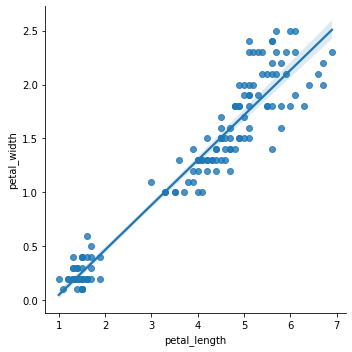

In [73]:
#pandas 컬럼명 넣어야함
import seaborn as sns
sns.lmplot(x="petal_length",y="petal_width",data=iris)

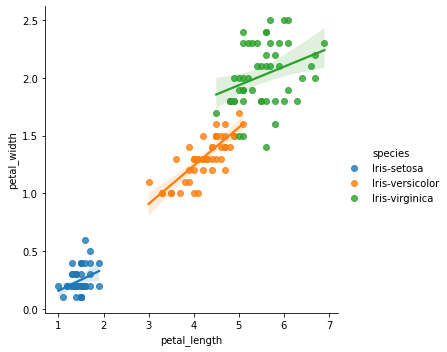

In [74]:
import seaborn as sns
sns.lmplot(x="petal_length",y="petal_width",data=iris,hue='species')

In [75]:
from sklearn.datasets import make_classification

X, Y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0)

In [76]:
X[:5] #연속적이므로 bi~multi~에는 해당안됨. 정규분포

array([[-1.07833384, -1.35575073],
       [-1.86047403,  1.74735208],
       [-2.01007335, -0.7945822 ],
       [-0.73029861,  0.76421034],
       [ 1.08057118, -0.82343188]])

In [77]:
Y[:5]

array([0, 1, 0, 1, 0])

In [81]:
X.mean(), X.std()

(-0.0006722252252260929, 1.2688044272817758)

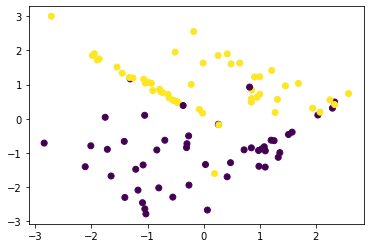

In [79]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], marker='o', c=Y)
plt.show()

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [83]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(binarize=0.0)

In [84]:
bnb.fit(X_train, Y_train)

BernoulliNB()

In [85]:
list(zip(bnb.predict(X_test),Y_test, X_test)) #zip: 묶어줌 출력은x / list:출력해줌

[(0, 0, array([ 0.97901449, -0.93227946])),
 (1, 1, array([0.85658007, 0.84047083])),
 (1, 1, array([0.95031328, 0.62536462])),
 (0, 0, array([ 0.48018012, -1.29005036])),
 (1, 1, array([-0.92939892,  1.03714597])),
 (0, 0, array([ 1.03763456, -0.88349253])),
 (0, 0, array([-1.08895219, -2.46147875])),
 (1, 1, array([0.90766275, 1.22264456])),
 (0, 0, array([ 1.35890267, -0.99478892])),
 (1, 1, array([-0.1765491 ,  2.55203501])),
 (1, 1, array([-2.71455857,  2.99993235])),
 (1, 1, array([1.3158933 , 0.56551719])),
 (1, 1, array([-1.98383931,  1.85136818])),
 (0, 0, array([ 1.25680801, -0.6445314 ])),
 (1, 1, array([0.4225284, 1.8986133])),
 (0, 1, array([ 0.19518882, -1.6078727 ])),
 (0, 0, array([-1.16966518, -2.09295699])),
 (1, 1, array([-0.7634465 ,  0.78893785])),
 (0, 0, array([-1.64896466, -1.67963928])),
 (1, 1, array([0.48846578, 1.60450336])),
 (0, 0, array([ 1.08057118, -0.82343188])),
 (1, 1, array([-1.03903367,  1.04115254])),
 (1, 1, array([1.2745579 , 0.18212925])),
 (0,

In [86]:
bnb.predict([[1,1], [1,-1], [-1,1], [-1,-1], [0,0]])

array([1, 0, 1, 0, 0])

In [88]:
bnb.score(X_test, Y_test) #xtest(2차원배열)넣으면 자동으로 그 예측값과 ytest를 비교

0.92

In [89]:
import numpy as np
_hwf = np.array([
        ('male',6,180,12),
        ('male',5.92,190,11),
        ('male',5.58,170,12),
        ('male',5.92,165,10),
        ('female',5,100,6),
        ('female',5.5,150,8),
        ('female',5.42,130,7),
        ('female',5.75,150,9)],
        dtype=[('sex', 'U6'), ('height', 'f4'), ('weight', 'i4'), ('foot', 'i4')
])

In [90]:
pr_m=0.5
# p(height|M) ~ N(6,남자키평균,남자키표준편차), 즉 N(6,5.855,0.187)
pr_f=0.5

In [91]:
prior_m = np.count_nonzero(_hwf['sex']=='male')/_hwf.shape[0]
prior_f = np.count_nonzero(_hwf['sex']=='female')/_hwf.shape[0]
f"prior_m: {prior_m}, prior_f: {prior_f}"

'prior_m: 0.5, prior_f: 0.5'

In [92]:
import pandas as pd
pdf=pd.DataFrame(_hwf)

In [93]:
pdf.head()

,sex,height,weight,foot
0,male,6.00,180,12
1,male,5.92,190,11
2,male,5.58,170,12
3,male,5.92,165,10
4,female,5.00,100,6


In [94]:
pdf.groupby('sex').mean()

,height,weight,foot
sex,,,
female,5.4175,132.50,7.50
male,5.8550,176.25,11.25


In [95]:
pdf.groupby('sex').std()

,height,weight,foot
sex,,,
female,0.311809,23.629078,1.290994
male,0.187172,11.086779,0.957427


In [96]:
# 함수로 만들기
def normpdf(x, mu=0, std=1):
    n = float(x-mu) / abs(std)
    g = np.exp(-n*n/2) / (abs(std) * np.sqrt(2*np.pi))
    return g

In [97]:
mean_h_m=_hwf['height'][_hwf['sex']=='male'].mean()
std_h_m=_hwf['height'][_hwf['sex']=='male'].std(ddof=1)
pr_h_m=normpdf(6, mean_h_m, std_h_m) #1.5788829647561371, 확률이 아니라 확률분포값
f"Pr(Height|Male): {pr_h_m:.4f}, mean_h_m: {mean_h_m:.4f}, std_h_m: {std_h_m:.4f}"

'Pr(Height|Male): 1.5789, mean_h_m: 5.8550, std_h_m: 0.1872'

In [98]:
mean_f_m=_hwf['foot'][_hwf['sex']=='male'].mean() #11.25
std_f_m=_hwf['foot'][_hwf['sex']=='male'].std(ddof=1) #0.957
pr_f_m=normpdf(8, std_f_m, std_f_m) #0.0013050759944537563
f"pr_h_m: {pr_f_m:.4f}, mean_h_m: {mean_f_m:.4f}, std_h_m: {std_f_m:.4f}"

'pr_h_m: 0.0000, mean_h_m: 11.2500, std_h_m: 0.9574'

In [99]:
mean_w_m=_hwf['weight'][_hwf['sex']=='male'].mean() #176.25
std_w_m=_hwf['weight'][_hwf['sex']=='male'].std(ddof=1) #11.0868
pr_w_m=normpdf(130, mean_w_m, std_w_m) #5.9869297985549439e-06
f"pr_w_m: {pr_w_m:.8f}, mean_w_m: {mean_w_m:.4f}, std_w_m: {std_w_m:.4f}"

'pr_w_m: 0.00000599, mean_w_m: 176.2500, std_w_m: 11.0868'

In [100]:
df = spark.createDataFrame(
    [
        [1,'I am sorry he has fleas poor dog'],
        [0,'take the dog to the park my dog would love it'],
        [1,'quit posting stupid worthless garbage'],
        [1,'my dog has fleas quit buying worthless dog food stupid'],
        [0,'dog is so cute I love him'],
        [1,u'우리 강아지 벼룩 미안해 불쌍해'],
        [0,u'강아지 공원 강아지 좋아해'],
        [1,u'너 멍청하게 쓸데없는 쓰레기 포스팅'],
        [1,u'강아지 벼룩 쓸데없는 강아지 음식 사지마 멍청하게'],
        [0,u'나 강아지 귀여워 좋아해']
    ],
    ['cls','sent']
)

In [101]:
from pyspark.ml.feature import StringIndexer

labelIndexer = StringIndexer(inputCol="cls", outputCol="label")

In [102]:
from pyspark.ml.feature import RegexTokenizer

regexTok = RegexTokenizer(inputCol="sent", outputCol="wordsRegex", pattern="\\s+")
#tokenizer = Tokenizer(inputCol="sent", outputCol="words")

In [103]:
from pyspark.ml.feature import StopWordsRemover

stop = StopWordsRemover(inputCol="wordsRegex", outputCol="nostops")

In [104]:
stopwords=list()
_stopwords=stop.getStopWords()
for e in _stopwords:
    stopwords.append(e)

In [105]:
_mystopwords=[u"나",u"너", u"우리", "take"]
for e in _mystopwords:
    stopwords.append(e)

In [106]:
stop.setStopWords(stopwords)

StopWordsRemover_1522ee85a4bc

In [107]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="nostops", outputCol="features")

In [108]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[labelIndexer,regexTok,stop,hashingTF])

In [109]:
model=pipeline.fit(df)
trainDf = model.transform(df)

In [110]:
trainDf.select("label","nostops","features").show(truncate=False)

+-----+--------------------------------------------------------+------------------------------------------------------------------------------------+
|label|nostops                                                 |features                                                                            |
+-----+--------------------------------------------------------+------------------------------------------------------------------------------------+
|0.0  |[sorry, fleas, poor, dog]                               |(262144,[6155,54556,85735,144961],[1.0,1.0,1.0,1.0])                                |
|1.0  |[dog, park, dog, love]                                  |(262144,[54556,71826,186480],[2.0,1.0,1.0])                                         |
|0.0  |[quit, posting, stupid, worthless, garbage]             |(262144,[1696,67357,111492,186022,247840],[1.0,1.0,1.0,1.0,1.0])                    |
|0.0  |[dog, fleas, quit, buying, worthless, dog, food, stupid]|(262144,[1696,6155,54556,111492,1211

In [111]:
trainDf.select('cls','label','features').show()

+---+-----+--------------------+
|cls|label|            features|
+---+-----+--------------------+
|  1|  0.0|(262144,[6155,545...|
|  0|  1.0|(262144,[54556,71...|
|  1|  0.0|(262144,[1696,673...|
|  1|  0.0|(262144,[1696,615...|
|  0|  1.0|(262144,[23837,54...|
|  1|  0.0|(262144,[5579,587...|
|  0|  1.0|(262144,[1510,587...|
|  1|  0.0|(262144,[81961,17...|
|  1|  0.0|(262144,[3425,587...|
|  0|  1.0|(262144,[58749,64...|
+---+-----+--------------------+



In [112]:
from pyspark.ml.classification import NaiveBayes
nb=NaiveBayes(featuresCol='features', labelCol='label', modelType='multinomial', predictionCol='prediction')

In [113]:
model = nb.fit(trainDf)

In [114]:
predictions=model.transform(trainDf)

In [115]:
predictions.select('label','sent','prediction').show()

+-----+----------------------------------+----------+
|label|                              sent|prediction|
+-----+----------------------------------+----------+
|  0.0|              I am sorry he has...|       0.0|
|  1.0|              take the dog to t...|       1.0|
|  0.0|              quit posting stup...|       0.0|
|  0.0|              my dog has fleas ...|       0.0|
|  1.0|              dog is so cute I ...|       1.0|
|  0.0|    우리 강아지 벼룩 미안해 불쌍해|       0.0|
|  1.0|         강아지 공원 강아지 좋아해|       1.0|
|  0.0|너 멍청하게 쓸데없는 쓰레기 포스팅|       0.0|
|  0.0| 강아지 벼룩 쓸데없는 강아지 음...|       0.0|
|  1.0|           나 강아지 귀여워 좋아해|       1.0|
+-----+----------------------------------+----------+

